# 4일차 과제 : DT 의사결정나무

sklearn의 GridSearchCV 함수를 사용해 최적의 매개 변수를 구하고,

최종 의사결정나무 모델을 만들고 해석하라. (모델 최적화, 인터넷 활용 GridSearchCV 조사)

데이터 : 유방암 데이터(변수: 31개, 자료 수: 569개)

-.목표변수(diagnosis, 0: Malignant(악성,212개), 1: Benign(양성,357개)

In [2]:
import numpy as np
from sklearn.preprocessing import scale, robust_scale, minmax_scale

from scipy import stats
import scipy.stats 
import pandas as pd
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV

%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings('ignore') #경고 무시

In [3]:
ds_bc = pd.read_csv('/home/pirl/Downloads/week4day1/유방암.csv',engine='python')
ds_bc.info()

#설명변수 X_i는 30개
#종속변수 Y는 이산형(1은 양성, 0은 악성)이지만 실제 분석에서는 연속형으로 처리
#결측치 없음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
diagnosis                  569 non-null int64
mean radius                569 non-null float64
mean texture               569 non-null float64
mean perimeter             569 non-null float64
mean area                  569 non-null float64
mean smoothness            569 non-null float64
mean compactness           569 non-null float64
mean concavity             569 non-null float64
mean concave points        569 non-null float64
mean symmetry              569 non-null float64
mean fractal dimension     569 non-null float64
radius error               569 non-null float64
texture error              569 non-null float64
perimeter error            569 non-null float64
area error                 569 non-null float64
smoothness error           569 non-null float64
compactness error          569 non-null float64
concavity error            569 non-null float64
concave points error       569 no

In [4]:
def remove_outlier_std(df):
    for i in range(0, len(df.iloc[1])):
        df = df[(np.abs(df.iloc[:,i] - df.iloc[:,i].mean()) < (3.6*df.iloc[:,i].std()))]
    return df
#3.6sigma를 벗어나는 data제거 함수

ds_bc_z=remove_outlier_std(ds_bc)
ds_bc_z.info()
#494개로 이상치 제거
#의사결정나무 알고리즘 특성상 이상치를 크게 신경쓰지 않아도 되지만
#data의 분포가 전반적으로 UCL을 초과하는 경향이 강하고
#모델의 일반성, 범용성을 위해 이상치 제거 실시

<class 'pandas.core.frame.DataFrame'>
Int64Index: 494 entries, 1 to 568
Data columns (total 31 columns):
diagnosis                  494 non-null int64
mean radius                494 non-null float64
mean texture               494 non-null float64
mean perimeter             494 non-null float64
mean area                  494 non-null float64
mean smoothness            494 non-null float64
mean compactness           494 non-null float64
mean concavity             494 non-null float64
mean concave points        494 non-null float64
mean symmetry              494 non-null float64
mean fractal dimension     494 non-null float64
radius error               494 non-null float64
texture error              494 non-null float64
perimeter error            494 non-null float64
area error                 494 non-null float64
smoothness error           494 non-null float64
compactness error          494 non-null float64
concavity error            494 non-null float64
concave points error       494 no

#  데이터 분할 7 : 3

In [5]:
bc_y=ds_bc_z["diagnosis"]
bc_x=ds_bc_z.drop("diagnosis",axis=1, inplace=False)
bc_train_x, bc_test_x, bc_train_y, bc_test_y = train_test_split(bc_x,bc_y,test_size=0.3, random_state=1234)
print("train data X size: {}".format(bc_train_x.shape))
print("train data Y size: {}".format(bc_train_y.shape))
print("test data X size: {}".format(bc_test_x.shape))
print("test data X size: {}".format(bc_test_y.shape))

train data X size: (345, 30)
train data Y size: (345,)
test data X size: (149, 30)
test data X size: (149,)


#  -------------------------------------------------------------------------
# GridSearch/ cri= gini or entropy, depth:1~19,  leaf_size:1~49
#  -------------------------------------------------------------------------

In [6]:
tree_uncustomized = DecisionTreeClassifier(random_state=1234)
tree_uncustomized.fit(bc_train_x,bc_train_y)
#훈련데이터 정확도
print("Accuracry on training set: {:.3f}".format(tree_uncustomized.score(bc_train_x,
                                                                        bc_train_y)))
#test 데이터 정확도
print("Accuracry on test set: {:.3f}".format(tree_uncustomized.score(bc_test_x,
                                                                       bc_test_y)))
#tree모형 생성

Accuracry on training set: 1.000
Accuracry on test set: 0.906


In [7]:
parameters = {  
              'criterion': ["gini", "entropy"],
              'max_depth': list(i for i in range(1,20)), 
              'min_samples_leaf': list(i for i in range(1,50))
             }

grid_obj = GridSearchCV(tree_uncustomized, parameters)
grid_obj

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

# parameter에 criterion, max_depth, min_samples_leaf만 조정
# GridSearchCV 함수에 의해 grid_obj 에 param_grid로 
# 모형을 만들 parameter의 값들을 보여줌


In [8]:
grid_obj = grid_obj.fit(bc_train_x, bc_train_y)
searchcv = grid_obj.best_estimator_
searchcv.fit(bc_train_x, bc_train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')

# 위의 주어진 train data를 이용해 해당 parameter를 조합해서 모든 모형을 만듦
# best_estimator로 최적의 parameter를 return함
# best_estimator로 
# criterion=gini, max_depth=5, min_samples_leaf=1 로 알려줌
# 주어진 parameter에 train data로 모형을 만듦

In [9]:
predictions = searchcv.predict(bc_test_x)
print("Accuracy on test set:", accuracy_score(bc_test_y, predictions).round(3))

Accuracy on test set: 0.906


#  해당 모형에 test data로 예측
#  해당 예측치와 실제 test y data로 정확도를 계산
#  계산 결과 정확도 0.906


# 정확도 0.906의 모델
# 동일 test data 기준으로는 더 높은 모형이 있을 수 있음

# train data를 기준으로 높은 정확도를 보여주는 parameter를 알려주기에
# test data에서도 최고값이라는 보장이 없음

# parameter들의 변경으로 더 높은 test 정확도의 모델이 존재할 수 있음

In [10]:
# tree.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
ds_feature_importance = pd.DataFrame()
ds_feature_importance["Feature"] = bc_train_x.columns
ds_feature_importance["Importance"] = searchcv.feature_importances_
# ds_feature_importance의 테이블을 중요도별로 정렬
ds_feature_importance.sort_values("Importance", ascending=False).head(9)

,Feature,Importance
7,mean concave points,0.690744
22,worst perimeter,0.078559
20,worst radius,0.065474
13,area error,0.042698
3,mean area,0.037159
11,texture error,0.031263
21,worst texture,0.030448
0,mean radius,0.012042
25,worst compactness,0.011612


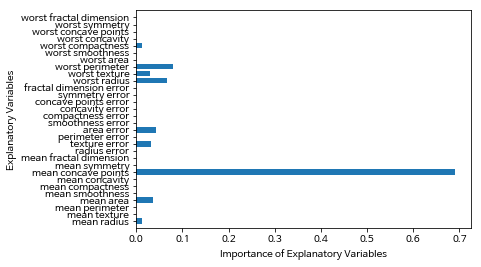

In [11]:
# 설명변수 중요도 그래프 함수 정의
def plot_feature_importances(model):
    n_features = bc_train_x.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align="center")
    plt.yticks(np.arange(n_features), bc_train_x.columns)
    plt.xlabel("Importance of Explanatory Variables")
    plt.ylabel("Explanatory Variables")
    plt.ylim(-1, n_features)

# 설명변수 중요도 그래프 함수 실행
plot_feature_importances(searchcv)

# mean concave points가 제일 중요한 변수이고 사실상 혼자 거의 다 분류
# worst radius, worst perimeter	도 영향을 주긴 하나 
# 일부 특이 data들의 처리에 쓰이는 것으로 예상


Grid_Search_Accuracy: 0.906


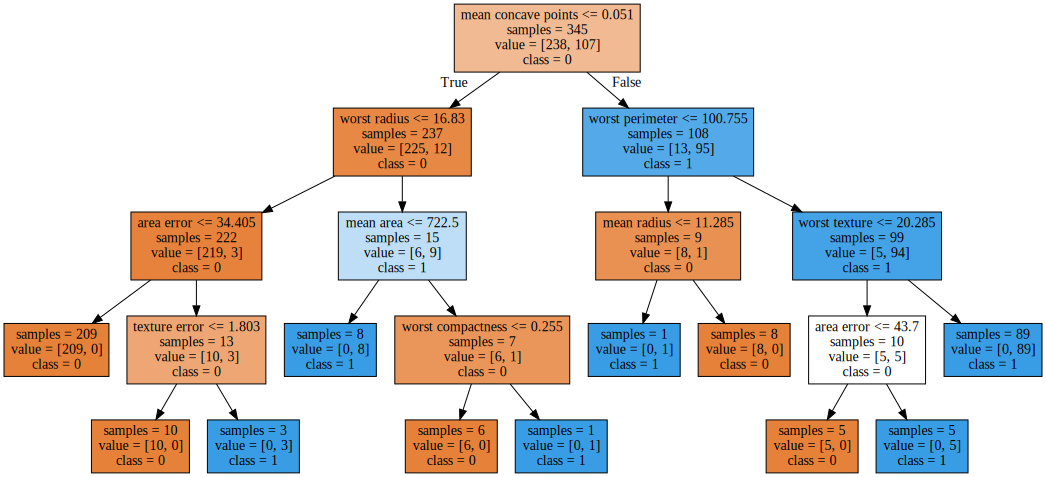

In [12]:
#트리모델 생성, criterion="gini" ,max_depth=5, min_samples_leaf=1 모델 생성
tree = DecisionTreeClassifier(criterion="gini",max_depth=5,random_state=1234,
                            min_samples_leaf=1)

tree.fit(bc_train_x,bc_train_y)

print("Grid_Search_Accuracy: {0:.3f}".format(tree.score(bc_test_x,bc_test_y).round(3)))

#트리모델을 tree.dot파일로 저장
export_graphviz(tree,out_file="tree.dot", class_names=["0","1"],
              feature_names=bc_train_x.columns,impurity=False,filled=True)
#path 설정:graphviz를 설치 했다면, 설치 된 경로를 설정. 기본 경로는 아래 예제 참고
os.environ["PATH"] += os.pathsep +""

#graphviz를 이용해 트리 모델 시각화
with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# 주어진 test data기준으로 0.906로 높은 정확도의 모델 
# 모든 최종 리프가 0, 1을 완벽히 분리 -> 과적합 위험, 일반성 보장이 약함

# 더욱 간결한 모델이 좋아보임
#   
# 해당 모델에서 
# mean concave points가 0.051보다 작거나 같으면 악성일 확률이 높고
# 0.051보다 크면 양성일 확률이 높음
# 변수 하나로 실질적으로 상당히 많이 구분하는 경향
#  

# 밑의 노드 분기 설명 변수 조건들은
# 일부 특이치 판별, 제거용이나
# 더욱 더 정확하게 분류, 판단하기 위한 조건 

# 처음에 많은 특성들의 초기값을 줄 때 기준이 될 수 있음

#  --------------------------------------------------------------------------------------------------------

#  
# manual parameter 선택을 위한 의사결정나무 모형 생성
#  

In [13]:
tree_un1 = DecisionTreeClassifier(random_state=1234)
tree_un1.fit(bc_train_x,bc_train_y)
#훈련데이터 정확도
print("Accuracry on training set: {:.3f}".format(tree_un1.score(bc_train_x,
                                                                        bc_train_y)))
#test 데이터 정확도
print("Accuracry on test set: {:.3f}".format(tree_un1.score(bc_test_x,
                                                                       bc_test_y)))

Accuracry on training set: 1.000
Accuracry on test set: 0.906


# 의사결정나무 parameter의 default:

In [14]:
tree_un1.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')>

#  
# 1.depth에 따른 정확도 변화 : 1~10
#  

In [15]:
#train 및 test정확도 결과 저장용
train_accuracy = []; test_accuracy=[]
#parameter 결과 테이블을 위함
para_criterion = []; para_max_depth = []
#최대 깊이 1~10까지 순차 실행
n_iter_depth = 10
#적용가능한 criterion:gini,entropy
list_criterion = ["gini","entropy"]
#criterion:gini,entropy & max_depth: 1~10까지 반복 실행
for criterion in list_criterion:
    for depth in range(1,n_iter_depth+1):
        tree2 = DecisionTreeClassifier(criterion=criterion,max_depth=depth,random_state=1234)
        tree2.fit(bc_train_x,bc_train_y)
        
        train_accuracy.append(tree2.score(bc_train_x,bc_train_y))
        test_accuracy.append(tree2.score(bc_test_x,bc_test_y))
        para_criterion.append(criterion)
        para_max_depth.append(depth)

In [16]:
#데이터 테이블로 저장
ds_accuracy2 = pd.DataFrame()
ds_accuracy2["Criterion"] = para_criterion
ds_accuracy2["Depth"] = para_max_depth
ds_accuracy2["TrainAccuracy"] = train_accuracy
ds_accuracy2["TestAccuracy"] = test_accuracy
ds_accuracy2.round(3)

,Criterion,Depth,TrainAccuracy,TestAccuracy
0,gini,1,0.928,0.899
1,gini,2,0.957,0.933
2,gini,3,0.980,0.919
3,gini,4,1.000,0.906
4,gini,5,1.000,0.906
5,gini,6,1.000,0.906
6,gini,7,1.000,0.906
7,gini,8,1.000,0.906
8,gini,9,1.000,0.906
9,gini,10,1.000,0.906


# 모델평가 
# depth가 증가할수록 정확도가 대체로 증가하는 경향
#  
# train : depth가 gini는 4, entropy는 5면 train 정확도가 1
# 4까지는 증가함수
#  
# test: 주어진 자료에서 gini는 4, entropy는 3 이후에 증가하지 않고 계속 동일, 상한
# entropy의 test 정확도가 높으나 대체로 비슷한 경향을 보임
#  
# entropy는 depth가 3이여도 꽤 높은 test 정확도

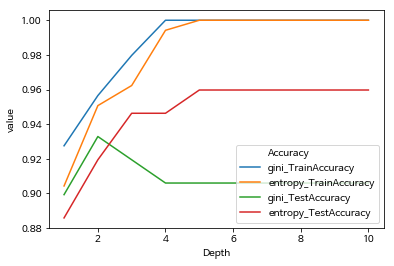

In [17]:
#데이터 테이블로 저장
ds_accuracy2_melt = pd.melt(ds_accuracy2,id_vars=["Criterion","Depth"])
ds_accuracy2_melt["Accuracy"] = ds_accuracy2_melt["Criterion"]+"_"+ds_accuracy2_melt["variable"]
sns.lineplot(x="Depth",y="value",hue="Accuracy",data=ds_accuracy2_melt)

# depth = 5 에서 entropy는 높은 test정확도를 보이나
# depth = 2 의 gini 지수도 나쁘지 않은 성능을 보이고
# 상대적으로 더 복잡한 모형보다는 간결한 모형이 좋기에
# depth = 2 채택을 고려

#  

#  
# 2-1.min_leaf_size에 따른 정확도 변화 : 2~16 
#  

In [18]:
#train 및 test정확도 결과 저장용
train_accuracy = []; test_accuracy=[]
#parameter 결과 테이블을 위함
para_criterion=[];para_max_depth = []; para_min_leaf_size=[]
#최대 깊이 5
max_depth = 5
#잎사귀 수 2~16까지 2단위로 순차 실행
list_min_leaf_size = [i*2 for i in range(1,9)]
#criterion:gini,entropy & min smaple size 10~50까지 반복 실행
for criterion in list_criterion:
    for leafsize in list_min_leaf_size:
        tree3 = DecisionTreeClassifier(criterion=criterion,max_depth=max_depth,
                                      min_samples_leaf=leafsize, random_state=1234)
        tree3.fit(bc_train_x,bc_train_y)
        train_accuracy.append(tree3.score(bc_train_x,bc_train_y))
        test_accuracy.append(tree3.score(bc_test_x,bc_test_y))
        para_criterion.append(criterion)
        para_max_depth.append(max_depth)
        para_min_leaf_size.append(leafsize)

In [19]:
#데이터 테이블로 저장
ds_accuracy3 = pd.DataFrame()
ds_accuracy3["Criterion"] = para_criterion
ds_accuracy3["Depth"] = para_max_depth
ds_accuracy3["MinLeafSize"] = para_min_leaf_size
ds_accuracy3["TrainAccuracy"] = train_accuracy
ds_accuracy3["TestAccuracy"] = test_accuracy
ds_accuracy3.round(3)

,Criterion,Depth,MinLeafSize,TrainAccuracy,TestAccuracy
0,gini,5,2,0.994,0.913
1,gini,5,4,0.983,0.906
2,gini,5,6,0.971,0.926
3,gini,5,8,0.957,0.953
4,gini,5,10,0.954,0.953
5,gini,5,12,0.968,0.926
6,gini,5,14,0.936,0.913
7,gini,5,16,0.933,0.913
8,entropy,5,2,0.997,0.946
9,entropy,5,4,0.986,0.946


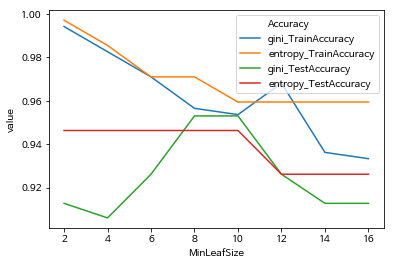

In [20]:
ds_accuracy3_melt = pd.melt(ds_accuracy3,id_vars=["Criterion","Depth","MinLeafSize"])
ds_accuracy3_melt["Accuracy"]=ds_accuracy3_melt["Criterion"]+"_"+ds_accuracy3_melt["variable"]
sns.lineplot(x="MinLeafSize",y="value",hue="Accuracy",data=ds_accuracy3_melt)

# train :
# min_leaf_size 2에서 높고 점차 감소하는 경향
#  
# test : 
# min_leaf_size 4~10에서는 gini가 증가하는 경향
# 10이상에서는 다시 감소하는 경향
# 2~7에서는 entropy가 정확도가 높고
# 8~12에서는 에서는 gini가 
# 다시 12 이상에서는 entropy가 높은 test 정확도


#  
# 2-2.min_leaf_size에 따른 정확도 변화 : 2~198 
#  

In [21]:
#train 및 test정확도 결과 저장용
train_accuracy = []; test_accuracy=[]
#parameter 결과 테이블을 위함
para_criterion=[];para_max_depth = []; para_min_leaf_size=[]
#최대 깊이 2
max_depth = 2
#잎사귀 수 2~198까지 2단위로 순차 실행
list_min_leaf_size = [i*2 for i in range(1,100)]
#criterion:gini,entropy & min smaple size 10~50까지 반복 실행
for criterion in list_criterion:
    for leafsize in list_min_leaf_size:
        tree3 = DecisionTreeClassifier(criterion=criterion,max_depth=max_depth,
                                      min_samples_leaf=leafsize, random_state=1234)
        tree3.fit(bc_train_x,bc_train_y)
        train_accuracy.append(tree3.score(bc_train_x,bc_train_y))
        test_accuracy.append(tree3.score(bc_test_x,bc_test_y))
        para_criterion.append(criterion)
        para_max_depth.append(max_depth)
        para_min_leaf_size.append(leafsize)

In [22]:
#데이터 테이블로 저장
ds_accuracy3 = pd.DataFrame()
ds_accuracy3["Criterion"] = para_criterion
ds_accuracy3["Depth"] = para_max_depth
ds_accuracy3["MinLeafSize"] = para_min_leaf_size
ds_accuracy3["TrainAccuracy"] = train_accuracy
ds_accuracy3["TestAccuracy"] = test_accuracy
#ds_accuracy3.round(3)

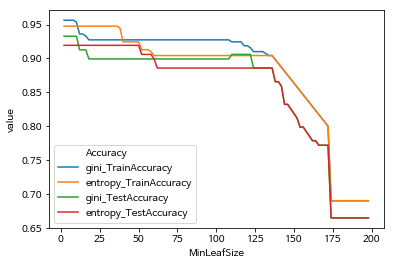

In [23]:
ds_accuracy3_melt = pd.melt(ds_accuracy3,id_vars=["Criterion","Depth","MinLeafSize"])
ds_accuracy3_melt["Accuracy"]=ds_accuracy3_melt["Criterion"]+"_"+ds_accuracy3_melt["variable"]
sns.lineplot(x="MinLeafSize",y="value",hue="Accuracy",data=ds_accuracy3_melt)

# test 정확도는 min_leaf_size가 커질 수록 대체로 감소하는 경향
# min_leaf_size 낮아야 정확도가 상승 (1일수록 정확히 분류)
# gini test 정확도는 상대적으로 증가하는 구간도 존재하나
# 60 이후로는 대체로 정확도 변동 거의 없음, 110 근처에서 일부 변동
# 약 130부터 계속 감소하다가 175 근방에서 급격하게 감소
# 12 이하의 낮은 leaf_size와 gini 지수가 높은 test 정확도를 보이나
# 경우에 따라 leaf_size 125를 넘어도 test 정확도가 0.9 근방이므로
# 정확도 허용범위 안이라면, 일반성을 위해 leaf_size를 키우는 것이 좋음

#  ----------------------------------------------------------------------
# 최종 의사 결정 나무 모형 : criterion="gini",max_depth=2, min_samples_leaf=10를 선택
#  ----------------------------------------------------------------------

Accuracy: 0.933


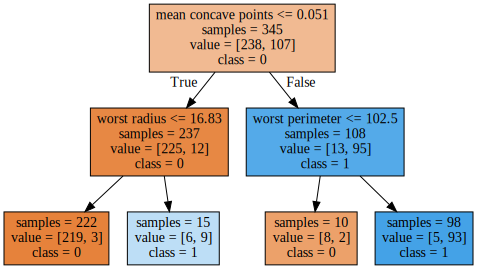

In [24]:
#트리모델 생성,criterion="gini",max_depth=2, min_samples_leaf=10으로 모델 생성
tree1 = DecisionTreeClassifier(criterion="gini",max_depth=2,random_state=1234,
                         min_samples_leaf=10)
#tree model training
tree1.fit(bc_train_x,bc_train_y)
print("Accuracy: {0:.3f}".format(tree1.score(bc_test_x,bc_test_y)))
#트리모델을 tree.dot파일로 저장
export_graphviz(tree1,out_file="tree.dot", class_names=["0","1"],
              feature_names=bc_train_x.columns,impurity=False,filled=True)
#path 설정:graphviz를 설치 했다면, 설치 된 경로를 설정. 기본 경로는 아래 예제 참고
os.environ["PATH"] += os.pathsep +""

#graphviz를 이용해 트리 모델 시각화
with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# 여러 parameter를 변경하면서 정확도를 개선
# criterion="gini",max_depth=2, min_samples_leaf=10를 선택
# 0.933의 정확도를 가진 모형
#  
# depth가 커지면 정확도는 올라가나 모델 자체가 복잡해져 일반성이 약해짐
# 위의 해당 모델은 depth가 낮아 판단 기준이 간결하고 쉽게 해석과 적용이 가능한 모델
#  min_samples_leaf가 작아지면 정확도는 올라가나, 최소 리프가 10이므로
#  일반성을 위해 10까지 최대로 키움 
#  
# mean concave points가 0.051보다 같거나 작으면 0: 악성일 확률이 높음
# 특히 worst radius가 16.83보다 같거나 작으면 매우 높은 확률로 악성
#  
# mean concave points가 0.051보다 크면 1: 양성일 확률이 높음
# 특히 worst perimeter가 100.755보다 크면 매우 높은 확률로 양성
